### Get EOFs and PCs from WVEL at 250 m (shelf break) barotropic run

Following the example in https://ajdawson.github.io/eofs/latest/api/eofs.standard.html

Using the package `eofs` by Andrew Dawson. 

Cite as:

Dawson, A. (2016). eofs: A library for EOF analysis of meteorological, oceanographic, and climate data. Journal of Open Research Software, 4(1).

This run is longer than the original one in Bagheera. 5 days vs 1 day.

In [1]:
import cmocean as cmo
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from eofs.standard import Eof
from eofs.examples import example_data_path
from xmitgcm import open_mdsdataset
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data and bathy
outdir = '/data/SO2/sio-kramosmusalem/07_barotropic_output/'
levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)

In [3]:
depth = ds.Depth[:]
lats = ds.YC[:,0].data
lons = ds.XC[0,:].data-360
hFacC = ds.hFacC.data
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)

In [4]:
nz = 42
print('%1.1f m depth' %ds.Zl[nz])

-250.2 m depth


In [5]:
w = ds.WVEL[:,nz,...].data
mask_w = np.expand_dims(mask[nz,:,:], axis=0) + np.zeros_like(w)
w_masked = np.ma.masked_array(w, mask=mask_w)

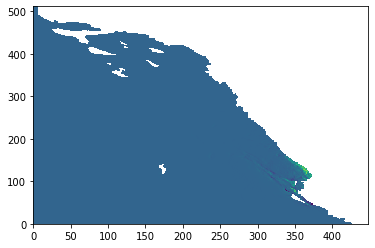

In [6]:
plt.pcolormesh(w_masked[10,:,:])

In [7]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lats))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(w_masked, weights=wgts) # I tried with weights=None and I got the same result. KRM

In [8]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof = solver.eofs(neofs=6,eofscaling=1)
eofCorr = solver.eofsAsCorrelation(neofs=6)
pc = solver.pcs(npcs=6, pcscaling=1)
varFact = solver.varianceFraction(neigs=6)

-250.2 m depth


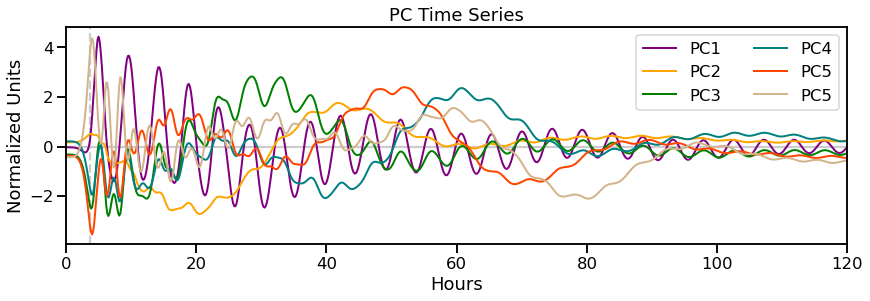

In [9]:
# Plot the leading PC time series.
sns.set_context('talk')
times = np.arange(0,720)*600
fig,ax = plt.subplots(1,1, figsize=(14,4))
ax.axhline(0, color='0.8')
ax.axvline(3.6, color='0.8', linestyle='--')
ax.plot(times[:]/3600, pc[:,0], color='purple', linewidth=2, label='PC1')
ax.plot(times[:]/3600, pc[:,1], color='orange', linewidth=2, label='PC2')
ax.plot(times[:]/3600, pc[:,2], color='green', linewidth=2, label='PC3')
ax.plot(times[:]/3600, pc[:,3], color='teal', linewidth=2, label='PC4')
ax.plot(times[:]/3600, pc[:,4], color='orangered', linewidth=2, label='PC5')
ax.plot(times[:]/3600, pc[:,5], color='tan', linewidth=2, label='PC5')
print('%1.1f m depth' %ds.Zl[nz])
ax.set_title('PC Time Series')
ax.set_xlabel('Hours')
ax.set_ylabel('Normalized Units')
ax.set_xlim(0,120)
#plt.ylim(-3, 3)
plt.legend(ncol=2)
plt.show()

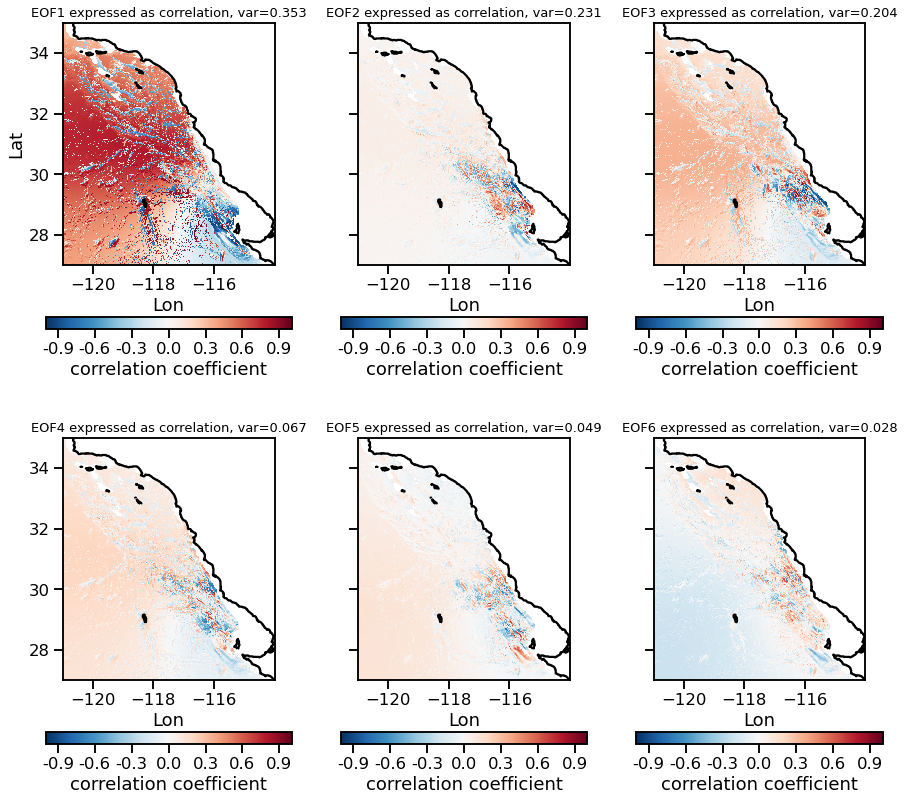

In [10]:
# Plof EOFs expressed as correlation between de PC time series and the time series 
# of the EOF input dataset at each gridpoint. Not related to EOFs computed from the correlation matrix.
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,14), sharey=True)
ax1.set_ylabel('Lat')
for nmode, ax in zip([0,1,2,3,4,5], [ax1,ax2,ax3,ax4,ax5,ax6]):
    cn = ax.pcolormesh(lons, lats, eofCorr[nmode].squeeze(),cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
    cb = plt.colorbar(cn, ax=ax, orientation='horizontal', 
                      format='%1.1f', pad=0.15, ticks=[-0.9,-0.6,-0.3,0,0.3,0.6,0.9])
    cb.set_label('correlation coefficient')
    ax.contour(lons,lats, depth, levels=[0], colors='k')
    ax.set_title('EOF%d expressed as correlation, var=%1.3f' %(nmode+1,varFact[nmode]), fontsize=13)
    ax.set_aspect(1)
    ax.set_xlabel('Lon')

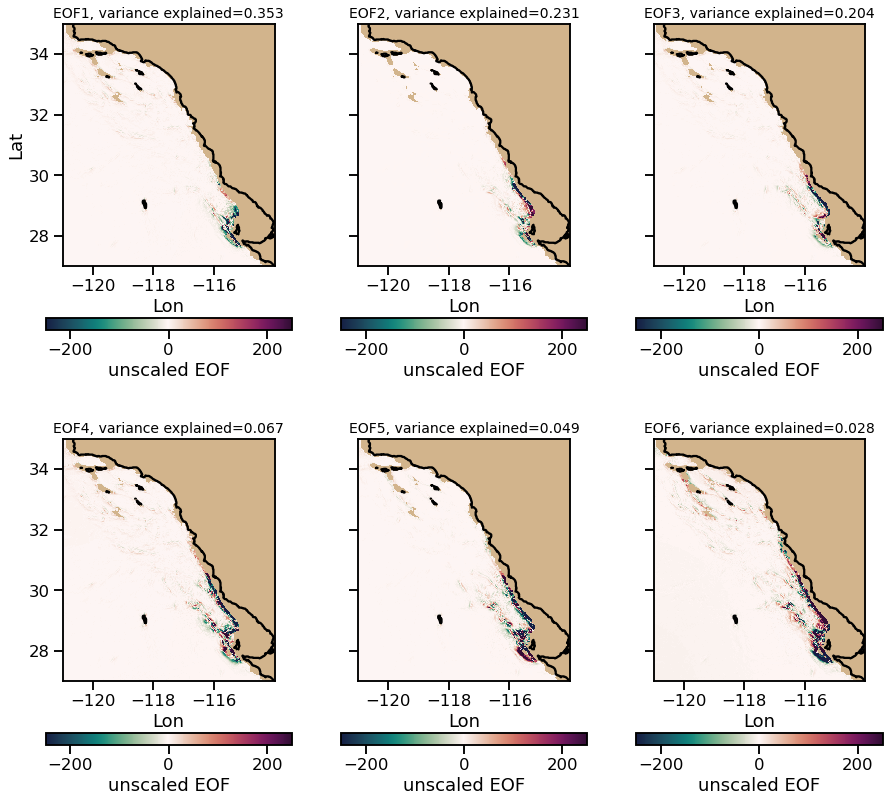

In [11]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,14), sharey=True)
ax1.set_ylabel('Lat')
for nmode, ax in zip([0,1,2,3,4,5], [ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.set_facecolor('tan')
    cn = ax.pcolormesh(lons, lats, np.ma.masked_array(eof[nmode].squeeze(),mask=mask[0,:,:]), 
                       cmap=cmo.cm.curl, vmin=-250, vmax=250)
    cb = plt.colorbar(cn, ax=ax, orientation='horizontal', pad=0.15)
    ax.contour(lons,lats, depth, levels=[0], colors='k')
    cb.set_label('unscaled EOF')
    ax.set_title('EOF%d, variance explained=%1.3f' %(nmode+1,varFact[nmode]), fontsize=14)
    ax.set_aspect(1)
    ax.set_xlabel('Lon')

### Reconstruct w field using each mode (animations)

In [12]:
#import matplotlib.animation as animation
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

In [13]:
def animate(tt,ax1,ax2,ax3,recon1,recon2,recon3,anim=True):
    cn = ax1.pcolormesh(lons, lats, np.ma.masked_array(recon1[tt,...].squeeze()*1e5,mask=mask[0,:,:]), 
                       cmap=cmo.cm.balance, vmin=-0.3, vmax=0.3)
    ax1.contour(lons,lats, depth, levels=[0], colors='k')
    
    cn = ax2.pcolormesh(lons, lats, np.ma.masked_array(recon2[tt,...].squeeze()*1e5,mask=mask[0,:,:]), 
                       cmap=cmo.cm.balance, vmin=-0.3, vmax=0.3)
    ax2.contour(lons,lats, depth, levels=[0], colors='k')
    
    cn = ax3.pcolormesh(lons, lats, np.ma.masked_array(recon3[tt,...].squeeze()*1e5,mask=mask[0,:,:]), 
                       cmap=cmo.cm.balance, vmin=-0.3, vmax=0.3)
    ax3.contour(lons,lats, depth, levels=[0], colors='k')
    
    if anim==True:
        if tt == 0:
            norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
            cbar_ax = fig.add_axes([0.26, 0.1, 0.5, 0.02])
            cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmo.cm.balance),
                              cax=cbar_ax, orientation='horizontal',label='w ($10^{-5}$ m/s)')
    else:
        norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
        cbar_ax = fig.add_axes([0.26, 0.1, 0.5, 0.02])
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmo.cm.balance),
                      cax=cbar_ax, orientation='horizontal',label='w ($10^{-5}$ m/s)')
    #if tt == 0:
    #    cb = plt.colorbar(cn, ax=ax, orientation='horizontal', pad=0.15)
    #    cb.set_label('Free surface (cm)')
    ax1.set_title('EOF1 %1.1f hrs, var explained=%1.3f' %(times[tt]/3600,varFact[0]))
    ax2.set_title('EOF2 %1.1f hrs, var explained=%1.3f' %(times[tt]/3600,varFact[1]))
    ax3.set_title('EOF3 %1.1f hrs, var explained=%1.3f' %(times[tt]/3600,varFact[2]))

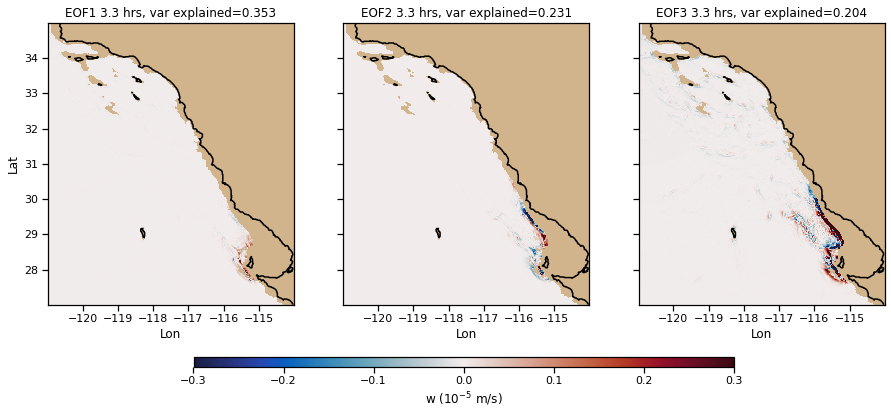

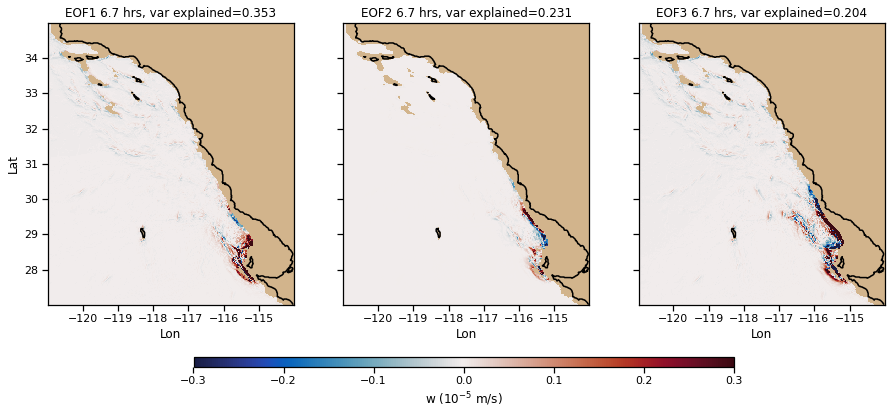

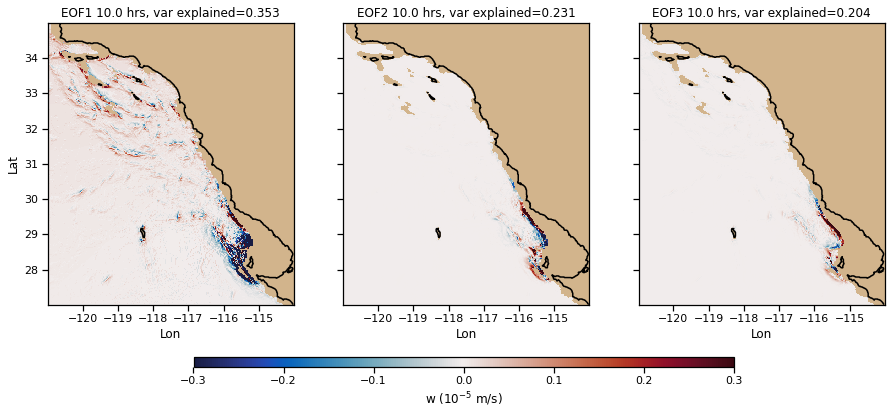

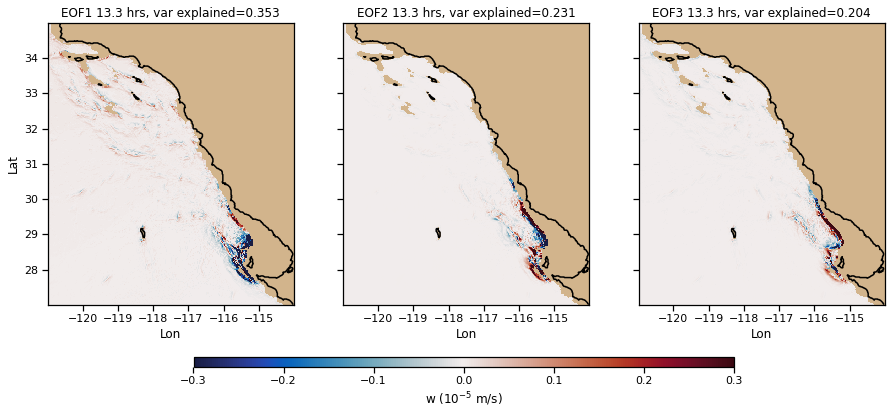

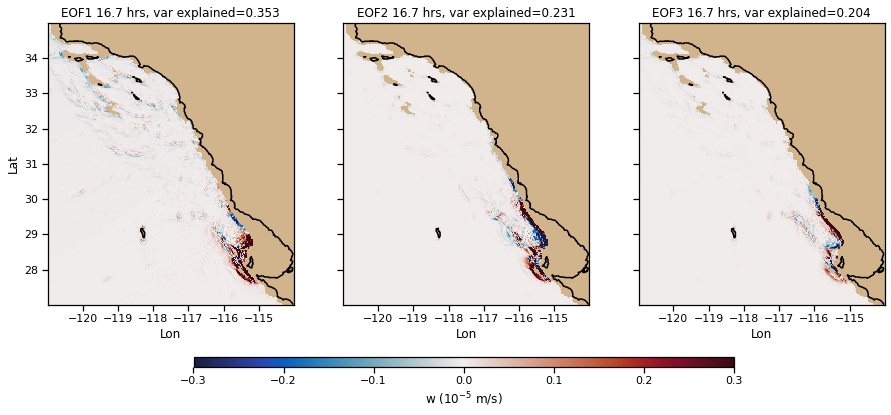

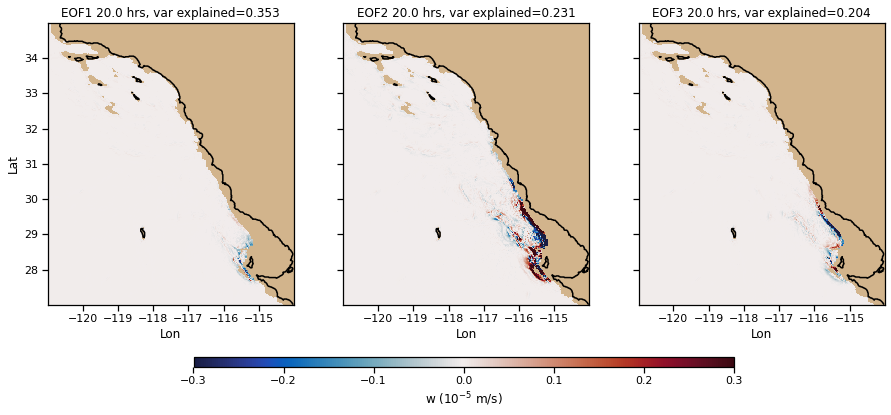

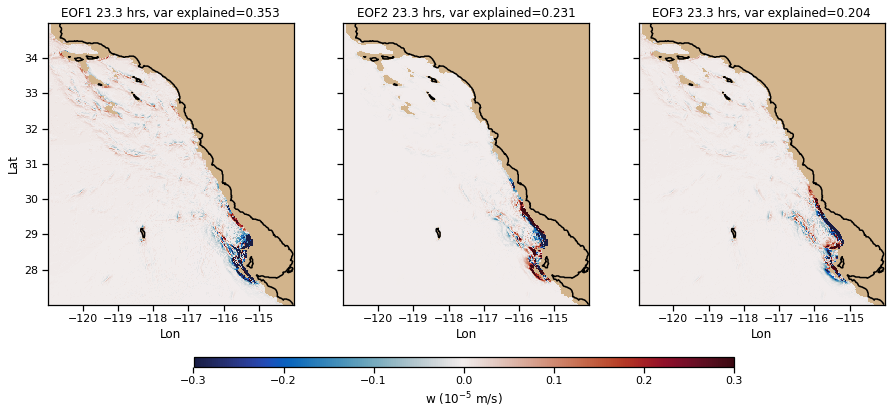

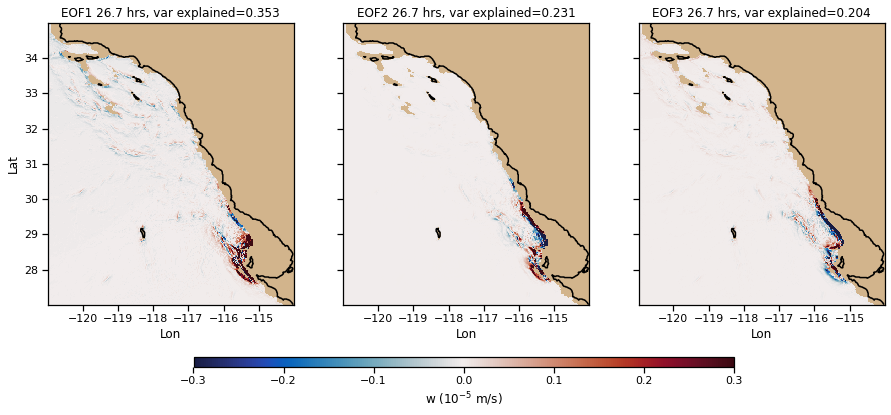

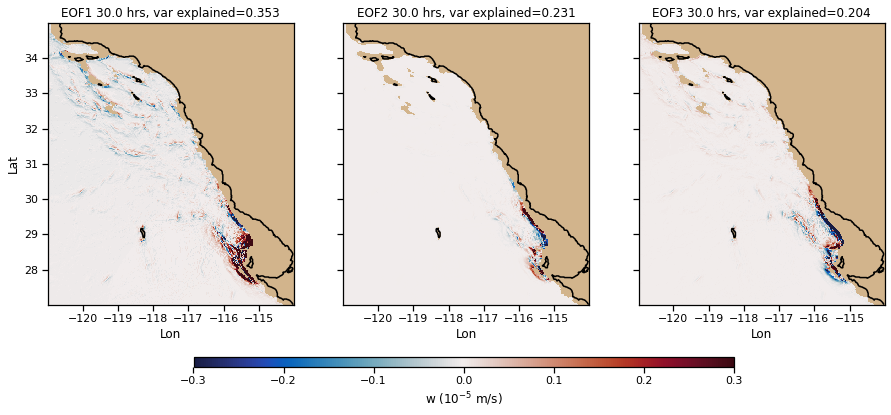

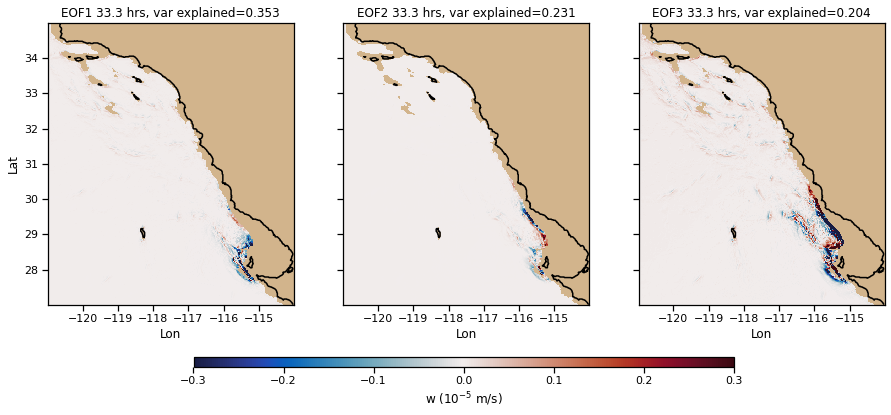

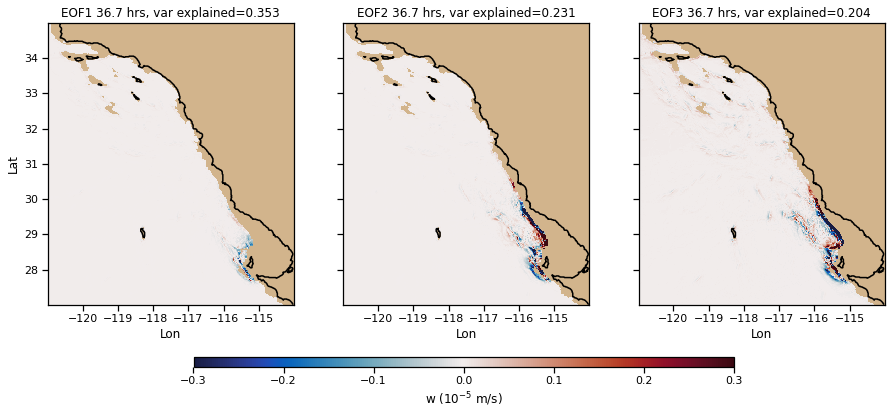

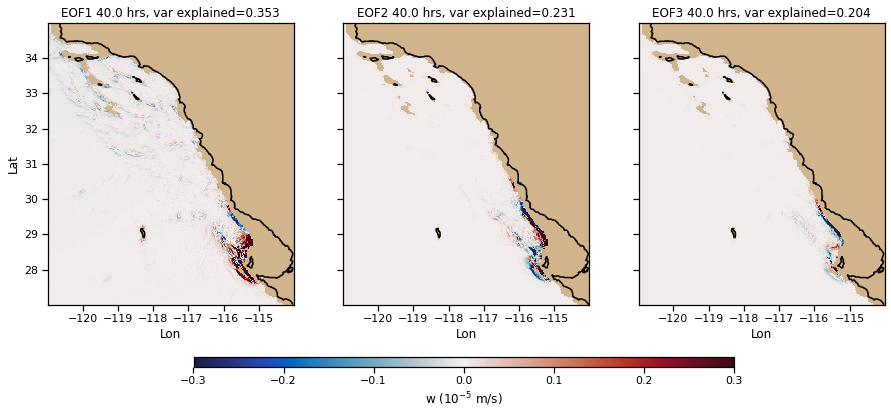

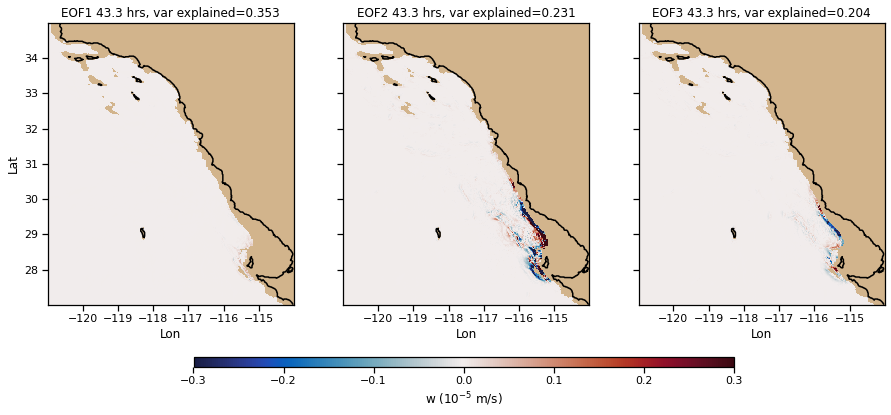

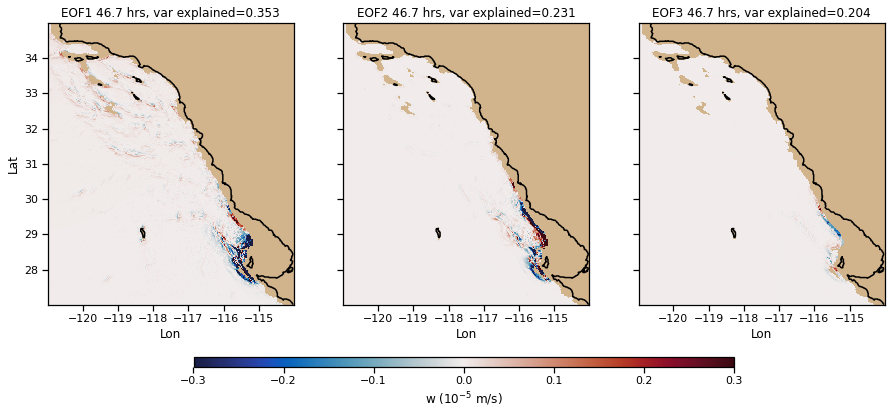

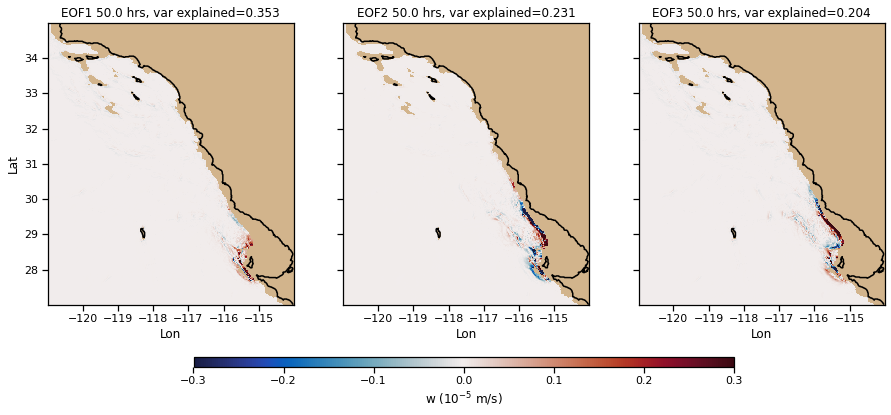

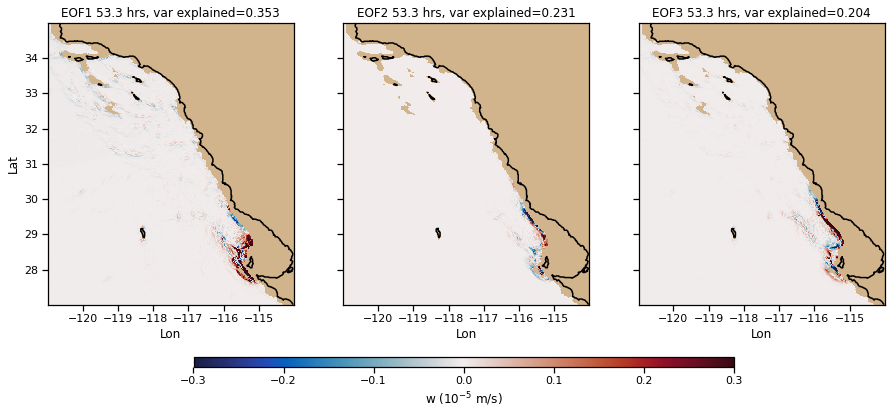

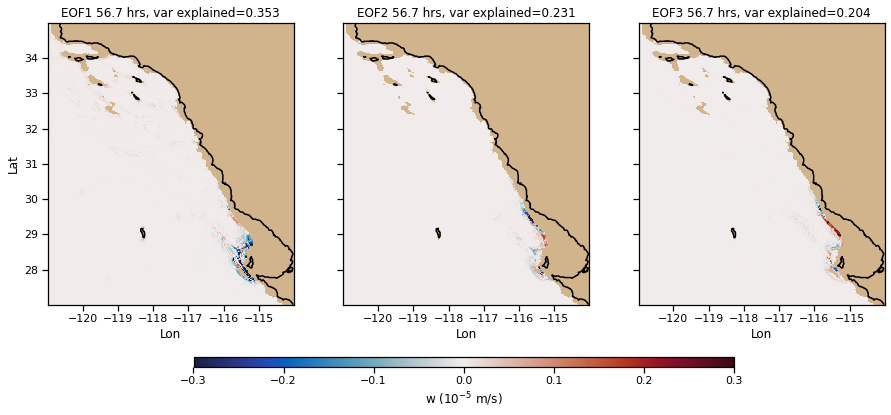

In [14]:
recon1 = solver.reconstructedField([1])
recon2 = solver.reconstructedField([2])
recon3 = solver.reconstructedField([3])

timess=range(20,360,20)

sns.set_context('notebook')
for tt in timess:
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,7), sharey=True)
    for ax in (ax1,ax2,ax3):
        ax.set_aspect(1)
        ax.set_xlabel('Lon') 
        ax.set_facecolor('tan')
    
    ax1.set_ylabel('Lat')

    animate(tt,ax1,ax2,ax3,recon1,recon2,recon3,anim=False)
